# Embeddings Playground

This notebook explores how tokens (from tokenization) get converted into embeddings - fixed-length numerical vectors that capture semantic meaning.

## Key Concepts:
- **Tokens** → **Embeddings** → **Model Processing**
- Embeddings are dense vector representations of tokens
- Similar tokens have similar embeddings (in vector space)
- Fixed dimensionality regardless of input length

In [3]:
# Import required libraries
import tiktoken
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import openai
import os

# For visualization
plt.style.use('default')

## From Tokens to Embeddings: The Journey

Let's trace how text becomes embeddings:

1. **Text** → "Hello world" 
2. **Tokenization** → [9906, 1917] (from notebook 01)
3. **Embedding Lookup** → Each token gets a fixed-size vector
4. **Result** → Matrix of embeddings

In [4]:
# Step 1: Tokenize text (connecting to notebook 01)
encoding = tiktoken.get_encoding("cl100k_base")

texts = [
    "Hello world",
    "Hello universe", 
    "Goodbye world",
    "Python programming",
    "Machine learning"
]

print("🔤 TOKENIZATION STEP:")
print("=" * 40)
for text in texts:
    tokens = encoding.encode(text)
    print(f"'{text}' → {tokens}")
    
    # Show the actual token pieces
    pieces = []
    for token in tokens:
        piece = encoding.decode([token])
        pieces.append(f"'{piece}'")
    print(f"  Token pieces: {' + '.join(pieces)}")
    print()

🔤 TOKENIZATION STEP:
'Hello world' → [9906, 1917]
  Token pieces: 'Hello' + ' world'

'Hello universe' → [9906, 15861]
  Token pieces: 'Hello' + ' universe'

'Goodbye world' → [15571, 29474, 1917]
  Token pieces: 'Good' + 'bye' + ' world'

'Python programming' → [31380, 15840]
  Token pieces: 'Python' + ' programming'

'Machine learning' → [22333, 6975]
  Token pieces: 'Machine' + ' learning'



## What Are Embeddings?

**Embeddings** are dense numerical vectors that represent tokens in a high-dimensional space where:
- Similar meanings → Similar vectors
- Each token has a **fixed-length vector** (e.g., 1536 dimensions for OpenAI's text-embedding-ada-002)
- Mathematical operations can capture semantic relationships

### Conceptual Example:
If embeddings were 3D instead of 1536D:
- "king" → [0.2, 0.8, 0.1]
- "queen" → [0.3, 0.9, 0.2] 
- "cat" → [0.7, 0.1, 0.9]

Notice: "king" and "queen" are closer to each other than to "cat"

In [5]:
# Simulate what embeddings look like conceptually
# (This is just for illustration - real embeddings are much more complex)

# Create some fake embeddings for demonstration
np.random.seed(42)  # For reproducible results

# Simulate 5-dimensional embeddings for some tokens
token_embeddings = {
    "Hello": np.random.normal(0.5, 0.1, 5),    # Greeting cluster
    "Hi": np.random.normal(0.5, 0.1, 5),       # Greeting cluster  
    "Goodbye": np.random.normal(-0.5, 0.1, 5), # Farewell cluster
    "Bye": np.random.normal(-0.5, 0.1, 5),     # Farewell cluster
    "world": np.random.normal(0.0, 0.1, 5),    # Noun cluster
    "universe": np.random.normal(0.0, 0.1, 5), # Noun cluster
    "Python": np.random.normal(0.8, 0.1, 5),   # Programming cluster
    "programming": np.random.normal(0.8, 0.1, 5) # Programming cluster
}

print("🧮 SIMULATED TOKEN EMBEDDINGS (5D):")
print("=" * 50)
for token, embedding in token_embeddings.items():
    print(f"'{token}': [{', '.join(f'{x:.2f}' for x in embedding)}]")

print("\n💡 Notice: Similar tokens have similar vector values!")

🧮 SIMULATED TOKEN EMBEDDINGS (5D):
'Hello': [0.55, 0.49, 0.56, 0.65, 0.48]
'Hi': [0.48, 0.66, 0.58, 0.45, 0.55]
'Goodbye': [-0.55, -0.55, -0.48, -0.69, -0.67]
'Bye': [-0.56, -0.60, -0.47, -0.59, -0.64]
'world': [0.15, -0.02, 0.01, -0.14, -0.05]
'universe': [0.01, -0.12, 0.04, -0.06, -0.03]
'Python': [0.74, 0.99, 0.80, 0.69, 0.88]
'programming': [0.68, 0.82, 0.60, 0.67, 0.82]

💡 Notice: Similar tokens have similar vector values!


🎯 3D VISUALIZATION OF CONCEPTUAL EMBEDDINGS:
Distance measurements:
  'king' ↔ 'queen': 0.173
  'king' ↔ 'cat':   1.175
  'queen' ↔ 'cat':  1.136

💡 Notice: king and queen are 6.8x closer to each other than to cat!


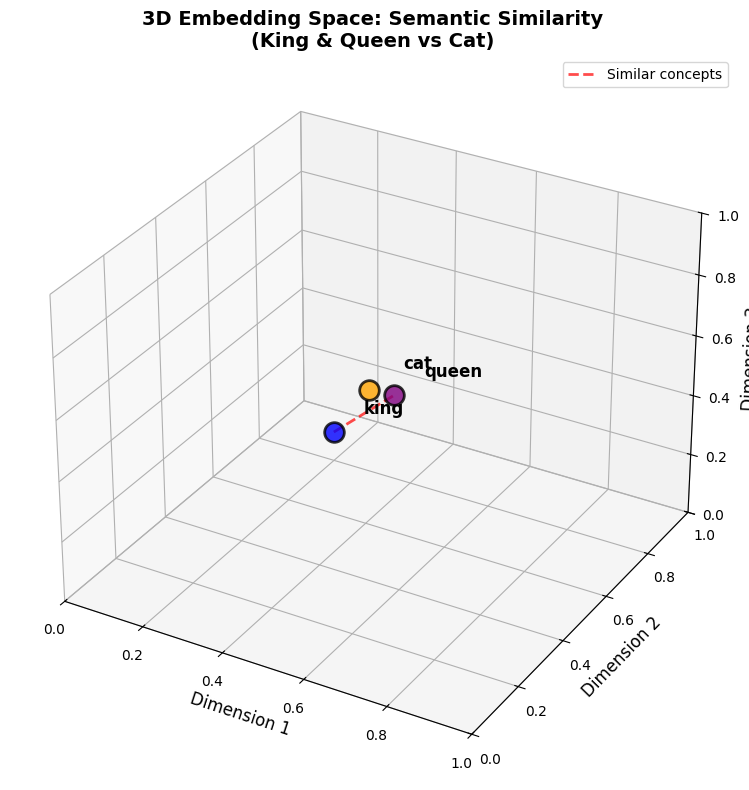


🧠 Key Insight:
This is how language models 'understand' that king and queen are related!
In real 1536D space, these relationships are much more nuanced and rich.


In [6]:
# 3D Visualization of the King/Queen/Cat Example
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the exact example from the explanation above
conceptual_embeddings = {
    "king": [0.2, 0.8, 0.1],
    "queen": [0.3, 0.9, 0.2], 
    "cat": [0.7, 0.1, 0.9]
}

print("🎯 3D VISUALIZATION OF CONCEPTUAL EMBEDDINGS:")
print("=" * 50)

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each word
colors = {'king': 'blue', 'queen': 'purple', 'cat': 'orange'}

# Plot each word
for word, coords in conceptual_embeddings.items():
    x, y, z = coords
    ax.scatter(x, y, z, c=colors[word], s=200, alpha=0.8, edgecolors='black', linewidth=2)
    
    # Add labels with some offset for better visibility
    ax.text(x + 0.05, y + 0.05, z + 0.05, word, fontsize=12, fontweight='bold')

# Draw lines between king and queen to show they're close
king_coords = conceptual_embeddings["king"]
queen_coords = conceptual_embeddings["queen"]
ax.plot([king_coords[0], queen_coords[0]], 
        [king_coords[1], queen_coords[1]], 
        [king_coords[2], queen_coords[2]], 
        'r--', linewidth=2, alpha=0.7, label='Similar concepts')

# Calculate and display distances
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)**0.5

king_queen_dist = euclidean_distance(conceptual_embeddings["king"], conceptual_embeddings["queen"])
king_cat_dist = euclidean_distance(conceptual_embeddings["king"], conceptual_embeddings["cat"])
queen_cat_dist = euclidean_distance(conceptual_embeddings["queen"], conceptual_embeddings["cat"])

print(f"Distance measurements:")
print(f"  'king' ↔ 'queen': {king_queen_dist:.3f}")
print(f"  'king' ↔ 'cat':   {king_cat_dist:.3f}")
print(f"  'queen' ↔ 'cat':  {queen_cat_dist:.3f}")
print()
print(f"💡 Notice: king and queen are {king_cat_dist/king_queen_dist:.1f}x closer to each other than to cat!")

# Customize the plot
ax.set_xlabel('Dimension 1', fontsize=12)
ax.set_ylabel('Dimension 2', fontsize=12)
ax.set_zlabel('Dimension 3', fontsize=12)
ax.set_title('3D Embedding Space: Semantic Similarity\n(King & Queen vs Cat)', fontsize=14, fontweight='bold')

# Set axis limits for better view
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

# Add a grid
ax.grid(True, alpha=0.3)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

print(f"\n🧠 Key Insight:")
print(f"This is how language models 'understand' that king and queen are related!")
print(f"In real 1536D space, these relationships are much more nuanced and rich.")

In [9]:
# Calculate cosine similarity between token embeddings
print("🔍 SIMILARITY ANALYSIS:")
print("=" * 40)

# Compare some pairs
comparisons = [
    ("Hello", "Hi"),           # Both greetings
    ("Hello", "Goodbye"),      # Opposite meanings  
    ("world", "universe"),     # Similar concepts
    ("Python", "programming"), # Related concepts
    ("Hello", "Python"),        # Unrelated
]

for token1, token2 in comparisons:
    emb1 = token_embeddings[token1].reshape(1, -1)
    similarity = cosine_similarity(emb1, emb2)[0][0]
    
    print(f"'{token1}' ↔ '{token2}': {similarity:.3f}")
    if similarity > 0.8:
        print("  → Very similar! 🎯")
    elif similarity > 0.3:
        print("  → Somewhat similar")
    elif similarity < -0.3:
        print("  → Opposite meanings! ↔️")
    else:
        print("  → Not very related")
    print()

🔍 SIMILARITY ANALYSIS:
'Hello' ↔ 'Hi': 0.973
  → Very similar! 🎯

'Hello' ↔ 'Goodbye': -0.987
  → Opposite meanings! ↔️

'world' ↔ 'universe': 0.495
  → Somewhat similar

'Python' ↔ 'programming': 0.997
  → Very similar! 🎯

'Hello' ↔ 'Python': 0.973
  → Very similar! 🎯



KeyError: 'Howdy'

## Real OpenAI Embeddings

Now let's get real embeddings from OpenAI's API. These are the actual vectors that models like GPT-4 use!

**Note**: You'll need an OpenAI API key. Set it as an environment variable or paste it below.

### Embedding Model Options: API vs Local

**OpenAI's `text-embedding-ada-002`:**
- ❌ **Not available as a local library** - API only
- ✅ **Requires OpenAI API key** and internet connection
- ✅ **High quality** embeddings (1536 dimensions)
- ✅ **Used by GPT-4** and other OpenAI models

**Local Alternatives (if you want to run offline):**
- 🏠 **Sentence Transformers**: `sentence-transformers` library
- 🏠 **Hugging Face models**: Many free embedding models
- 🏠 **Universal Sentence Encoder**: Google's model via TensorFlow

**Why use OpenAI's API embeddings?**
- Same embeddings used by GPT models
- Consistent with OpenAI's ecosystem
- High quality semantic understanding
- No local compute requirements

**Why use local alternatives?**
- No API costs
- Work offline
- Full control over the model
- Privacy (data doesn't leave your machine)

In [ ]:
# Example: Local embedding alternatives (if you want to avoid API calls)

print("🏠 LOCAL EMBEDDING ALTERNATIVES:")
print("=" * 50)

# Option 1: Try sentence-transformers (if available)
try:
    from sentence_transformers import SentenceTransformer
    
    # Load a popular local model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # 384 dimensions
    
    test_texts = ["king", "queen", "cat"]
    local_embeddings = model.encode(test_texts)
    
    print("✅ Sentence Transformers available!")
    print(f"Model: all-MiniLM-L6-v2")
    print(f"Embedding dimensions: {local_embeddings.shape[1]}")
    print(f"Sample embedding shape: {local_embeddings[0].shape}")
    
    # Compare with our conceptual example
    from sklearn.metrics.pairwise import cosine_similarity
    
    print(f"\nLocal embedding similarities:")
    king_emb = local_embeddings[0].reshape(1, -1)
    queen_emb = local_embeddings[1].reshape(1, -1) 
    cat_emb = local_embeddings[2].reshape(1, -1)
    
    king_queen_sim = cosine_similarity(king_emb, queen_emb)[0][0]
    king_cat_sim = cosine_similarity(king_emb, cat_emb)[0][0]
    
    print(f"  'king' ↔ 'queen': {king_queen_sim:.4f}")
    print(f"  'king' ↔ 'cat':   {king_cat_sim:.4f}")
    print(f"  Local model also shows king/queen are more similar! 🎯")
    
    local_available = True
    
except ImportError:
    print("❌ sentence-transformers not installed")
    print("To install: pip install sentence-transformers")
    local_available = False
except Exception as e:
    print(f"❌ Error with local embeddings: {e}")
    local_available = False

print(f"\n📊 Summary:")
print(f"OpenAI API: {'✅ Available' if api_available else '❌ Not configured'}")
print(f"Local models: {'✅ Available' if local_available else '❌ Not installed'}")

if not api_available and not local_available:
    print(f"\n💡 To get started:")
    print(f"  Option 1: Set OPENAI_API_KEY environment variable") 
    print(f"  Option 2: pip install sentence-transformers")

In [14]:
# Setup OpenAI API (you'll need your API key)
# Option 1: Set environment variable OPENAI_API_KEY
# Option 2: Uncomment and add your key below
# openai.api_key = "your-api-key-here"

# Check if API key is available
try:
    client = openai.OpenAI()  # Will use OPENAI_API_KEY env var
    print("✅ OpenAI API key found!")
    api_available = True
except:
    print("❌ OpenAI API key not found.")
    print("Set OPENAI_API_KEY environment variable or uncomment the line above.")
    api_available = False

✅ OpenAI API key found!


In [15]:
# Get real embeddings from OpenAI
if api_available:
    def get_embedding(text, model="text-embedding-ada-002"):
        """Get embedding for a text using OpenAI's API"""
        response = client.embeddings.create(
            input=text,
            model=model
        )
        return np.array(response.data[0].embedding)
    
    # Test words for embedding analysis
    test_words = [
        "king", "queen", "man", "woman",
        "cat", "dog", "animal",
        "happy", "joyful", "sad",
        "Python", "programming", "code"
    ]
    
    print("🌐 GETTING REAL OPENAI EMBEDDINGS...")
    print("=" * 50)
    
    real_embeddings = {}
    for word in test_words:
        try:
            embedding = get_embedding(word)
            real_embeddings[word] = embedding
            print(f"✅ '{word}': {len(embedding)}D vector")
        except Exception as e:
            print(f"❌ Error getting embedding for '{word}': {e}")
            break
    
    if real_embeddings:
        sample_word = list(real_embeddings.keys())[0]
        sample_embedding = real_embeddings[sample_word]
        print(f"\n📊 Embedding details:")
        print(f"Dimensions: {len(sample_embedding)}")
        print(f"Sample values for '{sample_word}': [{', '.join(f'{x:.4f}' for x in sample_embedding[:5])}...]")
        print(f"Value range: {sample_embedding.min():.4f} to {sample_embedding.max():.4f}")
else:
    print("⚠️  Skipping real embeddings - API key not available")
    print("We'll continue with simulated examples")

🌐 GETTING REAL OPENAI EMBEDDINGS...
✅ 'king': 1536D vector
✅ 'queen': 1536D vector
✅ 'man': 1536D vector
✅ 'woman': 1536D vector
✅ 'cat': 1536D vector
✅ 'dog': 1536D vector
✅ 'animal': 1536D vector
✅ 'happy': 1536D vector
✅ 'joyful': 1536D vector
✅ 'sad': 1536D vector
✅ 'Python': 1536D vector
✅ 'programming': 1536D vector
✅ 'code': 1536D vector

📊 Embedding details:
Dimensions: 1536
Sample values for 'king': [0.0100, -0.0039, 0.0074, -0.0117, -0.0320...]
Value range: -0.6654 to 0.1973


In [16]:
# Analyze real embedding similarities
if api_available and real_embeddings:
    print("🔍 REAL EMBEDDING SIMILARITIES:")
    print("=" * 50)
    
    # Interesting word pairs to compare
    word_pairs = [
        ("king", "queen"),        # Gender relationship
        ("man", "woman"),         # Gender relationship
        ("cat", "dog"),           # Both animals
        ("happy", "joyful"),      # Synonyms
        ("happy", "sad"),         # Opposites
        ("Python", "programming"), # Related concepts
        ("cat", "programming"),   # Unrelated
    ]
    
    for word1, word2 in word_pairs:
        if word1 in real_embeddings and word2 in real_embeddings:
            emb1 = real_embeddings[word1].reshape(1, -1)
            emb2 = real_embeddings[word2].reshape(1, -1)
            similarity = cosine_similarity(emb1, emb2)[0][0]
            
            print(f"'{word1}' ↔ '{word2}': {similarity:.4f}")
            
            # Interpret the similarity
            if similarity > 0.8:
                print("  → Extremely similar! 🎯")
            elif similarity > 0.6:
                print("  → Very similar! ✨")
            elif similarity > 0.4:
                print("  → Moderately similar 📊")
            elif similarity > 0.2:
                print("  → Somewhat similar 🔍")
            else:
                print("  → Not very similar 🔀")
            print()
else:
    print("⚠️ Skipping real similarity analysis - embeddings not available")

🔍 REAL EMBEDDING SIMILARITIES:
'king' ↔ 'queen': 0.9152
  → Extremely similar! 🎯

'man' ↔ 'woman': 0.9023
  → Extremely similar! 🎯

'cat' ↔ 'dog': 0.8630
  → Extremely similar! 🎯

'happy' ↔ 'joyful': 0.8887
  → Extremely similar! 🎯

'happy' ↔ 'sad': 0.8677
  → Extremely similar! 🎯

'Python' ↔ 'programming': 0.8651
  → Extremely similar! 🎯

'cat' ↔ 'programming': 0.8010
  → Extremely similar! 🎯



## Visualizing Embeddings

Since embeddings are high-dimensional (1536D), we can't visualize them directly. But we can use **dimensionality reduction** to project them into 2D space for visualization.

In [ ]:
# Visualize embeddings using PCA (Principal Component Analysis)
if api_available and real_embeddings and len(real_embeddings) > 2:
    print("📊 VISUALIZING EMBEDDINGS IN 2D:")
    print("=" * 40)
    
    # Prepare data for PCA
    words = list(real_embeddings.keys())
    embeddings_matrix = np.array([real_embeddings[word] for word in words])
    
    # Reduce from 1536D to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_matrix)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Define colors for different categories
    colors = {
        'royal': ['king', 'queen'],
        'gender': ['man', 'woman'], 
        'animals': ['cat', 'dog', 'animal'],
        'emotions': ['happy', 'joyful', 'sad'],
        'tech': ['Python', 'programming', 'code']
    }
    
    color_map = {}
    color_list = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (category, word_list) in enumerate(colors.items()):
        for word in word_list:
            if word in words:
                color_map[word] = color_list[i % len(color_list)]
    
    # Plot points
    for i, word in enumerate(words):
        x, y = embeddings_2d[i]
        color = color_map.get(word, 'gray')
        plt.scatter(x, y, c=color, s=100, alpha=0.7)
        plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.title('OpenAI Embeddings Visualized in 2D Space\n(Using PCA Dimensionality Reduction)', fontsize=14)
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    for i, (category, word_list) in enumerate(colors.items()):
        plt.scatter([], [], c=color_list[i % len(color_list)], label=category.capitalize(), s=100, alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Interpretation:")
    print(f"- Words that are close together have similar meanings")
    print(f"- The PCA captures {pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]:.1%} of the variance")
    print(f"- This is a 2D projection of {embeddings_matrix.shape[1]}D space!")
    
else:
    print("⚠️ Skipping visualization - need embeddings from OpenAI API")

## How Embeddings Work in Language Models

### The Complete Pipeline:

1. **Text Input**: "Hello world"
2. **Tokenization**: [9906, 1917] (from notebook 01)
3. **Embedding Lookup**: Each token → 1536D vector
4. **Model Processing**: Attention, transformations, etc.
5. **Output**: Generated text, classifications, etc.

### Key Insights:
- **Fixed Size**: Every token gets the same size vector (1536D for OpenAI)
- **Learned**: Embeddings are learned during model training
- **Semantic**: Similar tokens have similar embeddings
- **Context-Independent**: Each token has one embedding (context comes later in the model)

In [ ]:
# Demonstrate the complete token-to-embedding pipeline
print("🔄 COMPLETE PIPELINE DEMONSTRATION:")
print("=" * 50)

sample_text = "Hello beautiful world"
print(f"📝 Input Text: '{sample_text}'")
print()

# Step 1: Tokenization
tokens = encoding.encode(sample_text)
print(f"🔤 Step 1 - Tokenization:")
print(f"  Tokens: {tokens}")
for i, token in enumerate(tokens):
    piece = encoding.decode([token])
    print(f"  Token {i+1}: {token} → '{piece}'")
print()

# Step 2: Embedding lookup (simulated)
print(f"🧮 Step 2 - Embedding Lookup:")
print(f"  Each token gets converted to a 1536D vector")
if api_available:
    try:
        full_embedding = get_embedding(sample_text)
        print(f"  Full text embedding shape: {full_embedding.shape}")
        print(f"  Sample values: [{', '.join(f'{x:.4f}' for x in full_embedding[:5])}...]")
    except:
        print("  (Simulated - would be 1536D vectors)")
else:
    print("  (Simulated - would be 1536D vectors)")
    for i, token in enumerate(tokens):
        piece = encoding.decode([token])
        print(f"  '{piece}' → [1536 dimensional vector]")

print()
print(f"📊 Result: {len(tokens)} tokens → {len(tokens)} embeddings → Ready for model processing!")

## Next Steps & Key Takeaways

### What We've Learned:
1. **Tokens → Embeddings**: Each token becomes a fixed-size vector
2. **Semantic Similarity**: Similar tokens have similar embeddings
3. **High Dimensional**: Real embeddings are 1536D (much richer than our examples)
4. **Foundation**: Embeddings are the foundation for all model processing

### The Journey So Far:
- **Notebook 01**: Text → Tokens (discrete IDs)
- **Notebook 02**: Tokens → Embeddings (dense vectors)
- **Next**: How models process these embeddings (attention, transformers, etc.)

### Key Questions Answered:
- ✅ How do models convert tokens to numbers they can work with?
- ✅ Why do similar words have similar representations?
- ✅ What does "fixed-length" mean in the context of variable-length text?

### Experiment Ideas:
1. Try getting embeddings for different languages
2. Explore embeddings for code vs. natural language
3. Test how embeddings change with context (spoiler: they don't at this stage!)
4. Calculate embedding similarity for your own word pairs